Problem Statement :
Predict heart attack likelihood in individuals aged 18–35 using demographics, lifestyle, medical history, and clinical test data to enable early diagnosis and prevention.

About this DataSet

** Demographics **
- Age: Captures the age range of individuals (18–35 years).
- Gender: Distribution among males, females, and others.
- Region: Geographical zones (e.g., North, South, East, West, etc.).
- Urban/Rural: Differentiates between urban and rural populations.
- Socioeconomic Status (SES): Low, middle, or high economic tiers.

** Lifestyle Factors **
- Smoking and Alcohol Consumption: Frequency categories (e.g., never, occasionally, regularly).
- Dietary Preferences: Vegetarian, non-vegetarian, and vegan choices.
- Physical Activity: Levels (sedentary, moderate, high).
- Screen Time: Hours spent on screens per day (digital exposure).
- Sleep Duration: Average sleep hours per night.

** Medical History **
- Family History of Heart Disease: Presence of hereditary risk.
- Diabetes and Hypertension: Binary indicators of chronic conditions.
- Cholesterol Levels: Total cholesterol in mg/dL.
BMI: Body mass index as an obesity metric.
- Stress Levels: Low, medium, or high.

** Clinical and Test Results **
- Blood Pressure (Sys/Dia): Systolic/diastolic pressure in mmHg.
- Resting Heart Rate: Beats per minute at rest.
- ECG Results: Normal or abnormal heart electrical activity.
- Chest Pain Type: Categories of pain experienced (typical, atypical, etc.).
- Maximum Heart Rate Achieved: During stress or exercise.
- Exercise-Induced Angina: Whether angina is triggered by exertion.
- Blood Oxygen Levels (SpO2%): Oxygen saturation in the bloodstream.
- Triglyceride Levels: Fat content in the blood (mg/dL).

** Target Variable **
- Heart Attack Likelihood: Binary target indicating the presence (Yes) or absence (No) of heart attack risk.

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna as op
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score
import optuna
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\HP\Documents\datascience projects\heart attack prediction\heart_attack_youngsters_india.csv")

In [3]:
# Clean column names
df.columns = df.columns.str.replace(r"\(.*?\)", "", regex=True).str.strip().str.replace(" ","_")

In [4]:
# Display first few rows of the dataset
df.head()

,Age,Gender,Region,Urban/Rural,SES,Smoking_Status,Alcohol_Consumption,Diet_Type,Physical_Activity_Level,Screen_Time,...,Stress_Level,Blood_Pressure,Resting_Heart_Rate,ECG_Results,Chest_Pain_Type,Maximum_Heart_Rate_Achieved,Exercise_Induced_Angina,Blood_Oxygen_Levels,Triglyceride_Levels,Heart_Attack_Likelihood
0,30,Male,East,Urban,Middle,Never,Regularly,Non-Vegetarian,Sedentary,3,...,High,177.0/63.1,82,Normal,Non-anginal,183,No,94.1,58,No
1,24,Female,East,Urban,Low,Occasionally,Occasionally,Non-Vegetarian,Sedentary,15,...,High,137.5/110.7,76,Normal,Non-anginal,118,No,97.1,341,No
2,24,Female,North,Urban,Low,Occasionally,Occasionally,Vegan,High,15,...,Low,138.3/76.6,86,Normal,Typical,164,No,92.7,373,Yes
3,27,Male,East,Urban,Middle,Occasionally,Never,Vegetarian,Sedentary,6,...,Medium,177.1/90.0,106,Normal,Non-anginal,188,No,98.4,102,Yes
4,21,Female,West,Rural,Low,Occasionally,Occasionally,Vegetarian,Moderate,4,...,Low,130.7/108.8,73,Normal,Atypical,216,No,94.9,235,No


### EDA

##### Step 1: EDA - Overview of the dataset

In [5]:
# To get data types and non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              10000 non-null  int64  
 1   Gender                           10000 non-null  object 
 2   Region                           10000 non-null  object 
 3   Urban/Rural                      10000 non-null  object 
 4   SES                              10000 non-null  object 
 5   Smoking_Status                   10000 non-null  object 
 6   Alcohol_Consumption              10000 non-null  object 
 7   Diet_Type                        10000 non-null  object 
 8   Physical_Activity_Level          10000 non-null  object 
 9   Screen_Time                      10000 non-null  int64  
 10  Sleep_Duration                   10000 non-null  int64  
 11  Family_History_of_Heart_Disease  10000 non-null  object 
 12  Diabetes           

In [6]:
# Summary statistics of numerical columns
df.describe()

,Age,Screen_Time,Sleep_Duration,Cholesterol_Levels,BMI,Resting_Heart_Rate,Maximum_Heart_Rate_Achieved,Blood_Oxygen_Levels,Triglyceride_Levels
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,26.601500,7.510700,6.489600,199.649000,27.44190,89.493400,159.683900,94.940730,275.010100
std,5.164239,4.626578,2.289327,57.561902,7.22374,17.318237,35.034037,2.883329,128.825994
min,18.000000,0.000000,3.000000,100.000000,15.00000,60.000000,100.000000,90.000000,50.000000
25%,22.000000,4.000000,4.000000,150.000000,21.20000,74.000000,129.000000,92.400000,164.000000
50%,27.000000,8.000000,6.000000,199.000000,27.50000,90.000000,160.000000,94.900000,277.000000
75%,31.000000,12.000000,8.000000,249.000000,33.70000,104.000000,190.000000,97.400000,385.000000
max,35.000000,15.000000,10.000000,300.000000,40.00000,119.000000,220.000000,100.000000,500.000000


##### Step 2: Check for missing values

In [7]:
df.isnull().sum()

Age                                0
Gender                             0
Region                             0
Urban/Rural                        0
SES                                0
Smoking_Status                     0
Alcohol_Consumption                0
Diet_Type                          0
Physical_Activity_Level            0
Screen_Time                        0
Sleep_Duration                     0
Family_History_of_Heart_Disease    0
Diabetes                           0
Hypertension                       0
Cholesterol_Levels                 0
BMI                                0
Stress_Level                       0
Blood_Pressure                     0
Resting_Heart_Rate                 0
ECG_Results                        0
Chest_Pain_Type                    0
Maximum_Heart_Rate_Achieved        0
Exercise_Induced_Angina            0
Blood_Oxygen_Levels                0
Triglyceride_Levels                0
Heart_Attack_Likelihood            0
dtype: int64

##### Step 3: Check for class distribution (Target Variable)

In [8]:
df['Heart_Attack_Likelihood'].value_counts()

Heart_Attack_Likelihood
No     7962
Yes    2038
Name: count, dtype: int64

##### Step 4: Visualize the target variable distribution

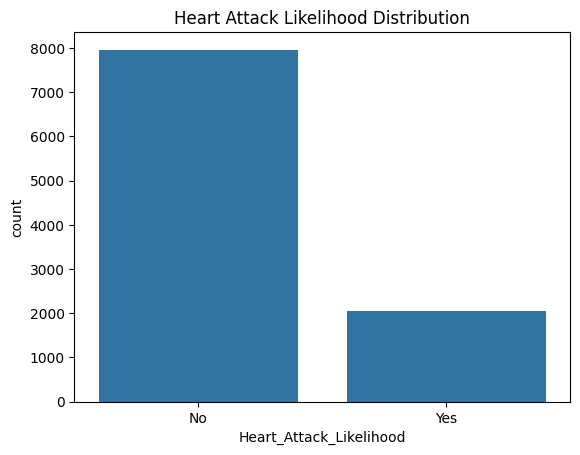

In [9]:
sns.countplot(x='Heart_Attack_Likelihood', data=df)
plt.title("Heart Attack Likelihood Distribution")
plt.show()

##### Step 5: Univariate Analysis - Visualizing distributions of numerical features

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Screen_Time'}>,
        <Axes: title={'center': 'Sleep_Duration'}>],
       [<Axes: title={'center': 'Cholesterol_Levels'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Resting_Heart_Rate'}>],
       [<Axes: title={'center': 'Maximum_Heart_Rate_Achieved'}>,
        <Axes: title={'center': 'Blood_Oxygen_Levels'}>,
        <Axes: title={'center': 'Triglyceride_Levels'}>]], dtype=object)

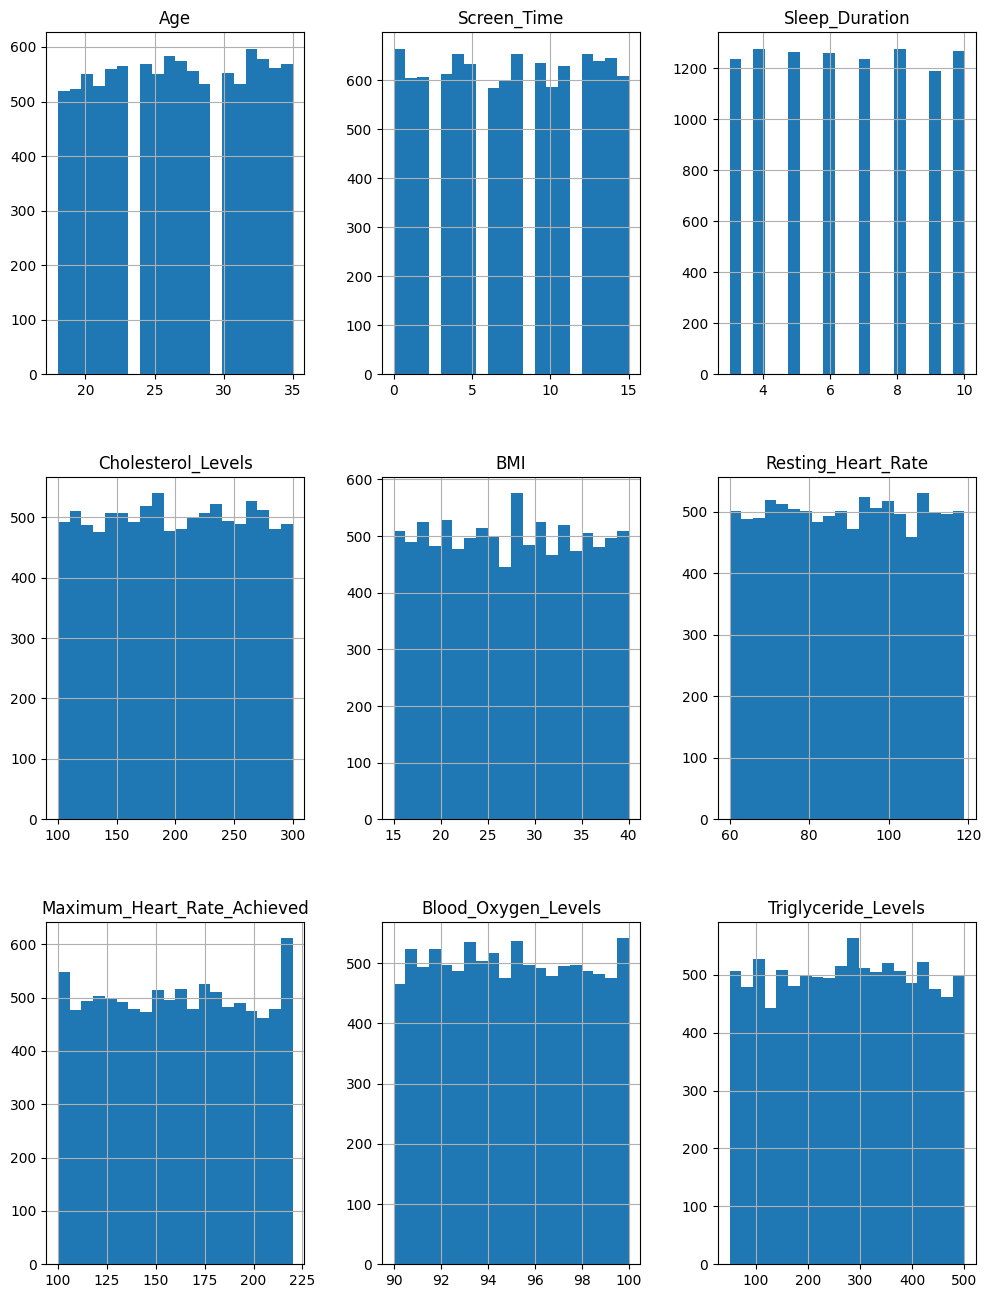

In [10]:
num_col = df.select_dtypes(["int64","float64"]).columns
df[num_col].hist(figsize = (12,16),bins =20)

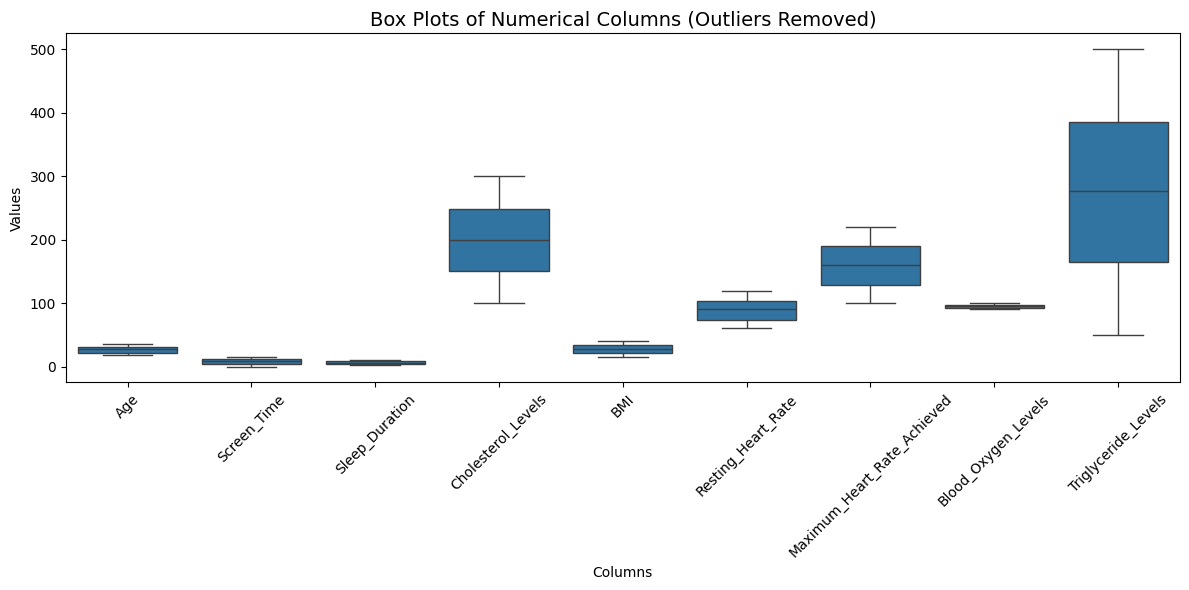

In [11]:
# Select numerical columns
num_col = df.select_dtypes(["int64", "float64"]).columns

# Filter outliers for all numerical columns
filtered_data = df.copy()
for col in num_col:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    filtered_data = filtered_data[(filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)]

# Melt the data for a combined boxplot
melted_data = filtered_data[num_col].melt(var_name="Columns", value_name="Values")

# Plot the combined boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_data, x="Columns", y="Values")
plt.title("Box Plots of Numerical Columns (Outliers Removed)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Step 6: Bivariate Analysis - Visualizing relationships between numerical features

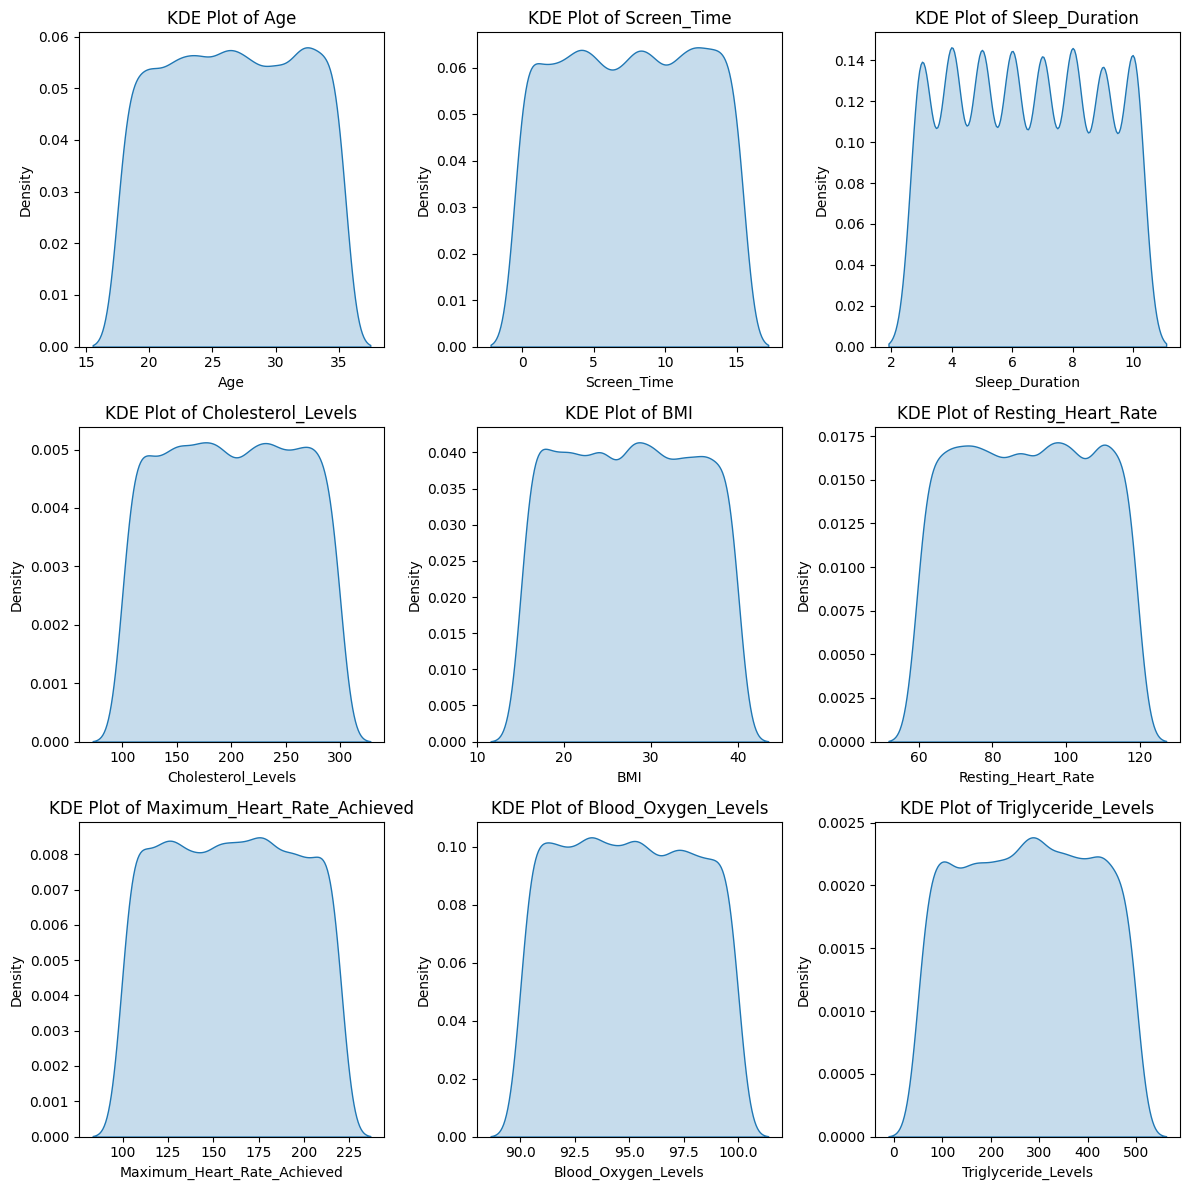

In [12]:
num_cols = df.select_dtypes(include=['number']).columns  

num_cols_per_row = 3 
num_rows = (len(num_cols) // num_cols_per_row) + (len(num_cols) % num_cols_per_row != 0)  # Calculate rows dynamically

plt.figure(figsize=(12, 4 * num_rows))

# Plot KDE for each numerical column
for i, col in enumerate(num_cols, 1):
    plt.subplot(num_rows, num_cols_per_row, i)  
    sns.kdeplot(x=df[col], fill=True)  
    plt.title(f'KDE Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

##### Step 7: Check for correlation between numerical features

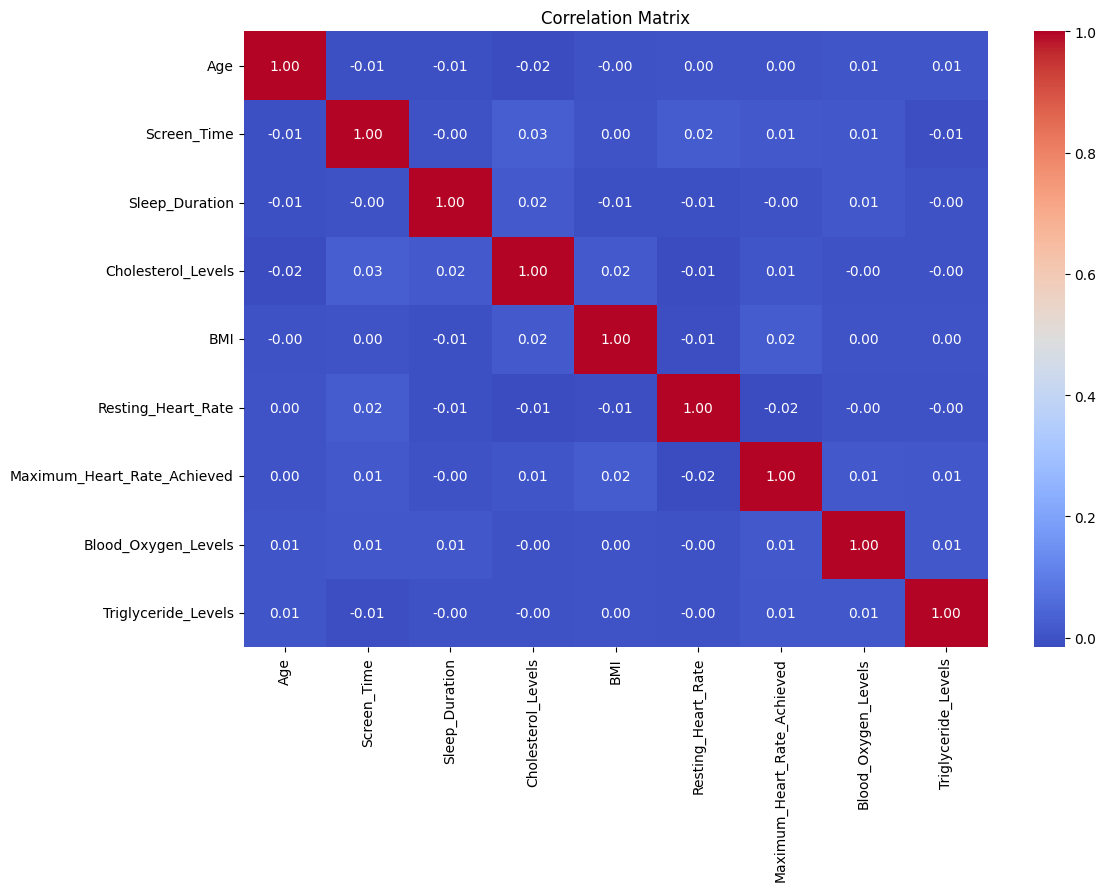

In [13]:
# Select only numeric columns for correlation
numerical_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

##### Step 8: Outlier Detection using IQR method

In [14]:
# Identify numerical features in the dataset
numerical_features = df.select_dtypes(include=[np.number]).columns

Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

In [15]:
# Filtering out outliers
df_no_outliers = df[~((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

##### Step 9: Separate Blood Pressure into Systolic and Diastolic

In [16]:
df_no_outliers["Systolic"] = df_no_outliers["Blood_Pressure"].str.split("/", expand=True)[0].astype("float")
df_no_outliers["Diastolic"] = df_no_outliers["Blood_Pressure"].str.split("/", expand=True)[1].astype("float64")
df_no_outliers.drop("Blood_Pressure", axis=1, inplace=True)



**High Impact (Directly Affect Heart Health):**

* **Blood Pressure:** High blood pressure is a major risk factor for heart attack.
* **Cholesterol Levels:** High cholesterol, particularly high LDL cholesterol, contributes to plaque buildup in arteries.
* **Diabetes:** Diabetes significantly increases the risk of heart disease and heart attack.
* **Smoking_Status:** Smoking is a major risk factor for heart attack.
* **Family_History_of_Heart_Disease:** A strong family history of heart disease increases your risk.
* **ECG_Results:** ECG results can reveal existing heart conditions or abnormalities that increase risk.
* **Chest_Pain_Type:** Chest pain (angina) is a common symptom of heart disease and a warning sign of potential heart attack.
* **Maximum_Heart_Rate_Achieved:** While not a direct cause, an abnormal maximum heart rate during exercise can indicate underlying heart issues.
* **Exercise_Induced_Angina:** Chest pain during exercise is a strong indicator of heart disease.
* **Triglyceride_Levels:** High triglyceride levels can contribute to heart disease, especially when combined with other risk factors.

**Moderate Impact (Indirectly Affect Heart Health):**

* **Age:** Risk of heart attack increases with age.
* **Gender:** Men are generally at higher risk of heart attack than women, especially before menopause.
* **Alcohol_Consumption:** Excessive alcohol consumption can damage the heart and increase risk.
* **Diet_Type:** A diet high in saturated fat, cholesterol, and sodium increases risk.
* **Physical_Activity_Level:** Lack of physical activity increases risk.
* **Sleep_Duration:** Poor sleep can contribute to heart disease.
* **BMI:** Obesity increases risk.
* **Stress_Level:** High stress levels can negatively impact heart health.
* **Resting_Heart_Rate:** A consistently high resting heart rate can be a risk factor.
* **Blood_Oxygen_Levels:** Chronically low blood oxygen levels can strain the heart.

**Lower Impact (Less Directly Related):**

* **Region:** While there might be regional variations in heart attack rates due to lifestyle or environmental factors, region itself is not a direct cause.
* **Urban/Rural:** Similar to region, the urban/rural setting might influence lifestyle factors, but it's not a direct cause.
* **SES:** Socioeconomic status can indirectly affect heart health due to access to healthcare, healthy food choices, and lifestyle factors.
* **Screen_Time:** Excessive screen time can contribute to a sedentary lifssessment of your heart attack risk.


##### Step 10: Drop unnecessary columns

In [17]:
columns_to_drop = [
    'Region', 'Urban/Rural', 'SES', 'Gender', 'Screen_Time', 'Diet_Type'
]
X = df_no_outliers.drop(columns=columns_to_drop)
y = df_no_outliers['Heart_Attack_Likelihood']

##### Step 11: Encode categorical columns using LabelEncoder

In [18]:
# Step 1: Separate features and target variable
X = df.drop(columns=['Heart_Attack_Likelihood'])  # Features
y = df['Heart_Attack_Likelihood']                # Target

# Step 2: Identify categorical columns in features
cat_cols = X.select_dtypes(include=['object']).columns

# Step 3: Encode categorical columns using LabelEncoder
encoder = LabelEncoder()
for col in cat_cols:
    X[col] = encoder.fit_transform(X[col])

# Step 4: Encode the target variable if it's categorical
if y.dtype == 'object':
    y = encoder.fit_transform(y)

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

##### Step 13: Split the dataset into train and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Step 14: Standardize the features

In [20]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train)
x_test_std = scaler.transform(X_test)

#### Finding Best Parameters using Optuna 

In [21]:
degree_cache = {}

In [22]:
degree_cache = {}
def objective(trial):
    model_name = trial.suggest_categorical("Algorithm", ['SVC', 'Logistic Regression', 'Decision Tree'])

    if model_name == 'Logistic Regression':
        poly_degree = trial.suggest_int("poly_degree", 1, 3)
        
        if poly_degree not in degree_cache:
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=poly_degree)),
                ('scaler', StandardScaler())
            ])
            x_train_poly = pipeline.fit_transform(X_train)
            degree_cache[poly_degree] = x_train_poly
        else:
            x_train_poly = degree_cache[poly_degree]

        solver_penalty_combinations = [
            ("lbfgs", "l2"),
            ("newton-cg", "l2"),
            ("sag", "l2"),
            ("saga", "l1"),
            ("saga", "l2"),
            ("saga", "elasticnet")
        ]
        solv, penalty = trial.suggest_categorical("solver_penalty", solver_penalty_combinations)
        c = trial.suggest_float("C", 1e-4, 1e3, log=True)

        if penalty == "elasticnet":
            l1_rto = trial.suggest_float("l1_ratio", 0.1, 0.9, step=0.1)
            model = LogisticRegression(
                C=c, 
                solver=solv, 
                penalty=penalty, 
                l1_ratio=l1_rto, 
                n_jobs=-1, 
                max_iter=1000,
                random_state=42
            )
        else:
            model = LogisticRegression(
                C=c, 
                solver=solv, 
                penalty=penalty, 
                n_jobs=-1, 
                max_iter=1000,
                random_state=42
            )

    elif model_name == 'SVC':
        c = trial.suggest_float("C", 1e-4, 1e3, log=True)
        ker_nel = trial.suggest_categorical("Kernel", ['linear', 'poly', 'rbf', 'sigmoid'])

        if ker_nel == 'poly':
            deg_ree = trial.suggest_int("Degree", 1, 3)
            model = SVC(
                C=c, 
                kernel=ker_nel, 
                degree=deg_ree,
                random_state=42
            )
        elif ker_nel in ['rbf', 'sigmoid']:
            gamma = trial.suggest_categorical("Gamma", ['scale', 'auto'])
            model = SVC(
                C=c, 
                kernel=ker_nel, 
                gamma=gamma,
                random_state=42
            )
        else:
            model = SVC(
                C=c,
                kernel=ker_nel,
                random_state=42
            )
    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int("max_depth", 3, 20)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
        criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])

        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            criterion=criterion,
            random_state=42
        )

    # Use transformed data for Logistic Regression, original data for others
    X_train_transformed = x_train_poly if model_name == 'Logistic Regression' else X_train

    try:
        cv_results = cross_validate(
            estimator=model,
            X=X_train_transformed,
            y=y_train,
            cv=3,
            scoring="accuracy",
            return_train_score=True,
            n_jobs=-1,
        )
        train_score = np.mean(cv_results['train_score'])
        test_score = np.mean(cv_results['test_score'])
    except ValueError as e:
        print(f"Error during cross-validation for model {model_name} with params {trial.params}: {e}")
        train_score = float("nan")
        test_score = float("nan")

    trial.set_user_attr("train_score", train_score)
    trial.set_user_attr("test_score", test_score)

    return test_score

In [23]:
# Create Optuna study and optimize
study = op.create_study(direction="maximize", sampler=op.samplers.TPESampler())

[I 2025-02-04 21:33:42,759] A new study created in memory with name: no-name-da111fcb-9ab6-4eb3-a8ee-c5a09ae4ac18


In [24]:
study.optimize(objective, n_jobs=-1, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 21:33:50,054] Trial 0 finished with value: 0.6871819377050135 and parameters: {'Algorithm': 'Decision Tree', 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.6871819377050135.
[I 2025-02-04 21:33:50,245] Trial 5 finished with value: 0.6922833932298705 and parameters: {'Algorithm': 'Decision Tree', 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 5 with value: 0.6922833932298705.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 21:33:50,348] Trial 3 finished with value: 0.6777611031891103 and parameters: {'Algorithm': 'Decision Tree', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 5 with value: 0.6922833932298705.
[I 2025-02-04 21:33:50,483] Trial 4 finished with value: 0.7257236208925363 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 1, 'solver_penalty': ('newton-cg', 'l2'), 'C': 0.01882743594805179}. Best is trial 4 with value: 0.7257236208925363.
[I 2025-02-04 21:33:50,530] Trial 2 finished with value: 0.7263515890318595 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 1, 'solver_penalty': ('newton-cg', 'l2'), 'C': 2.100324389436416}. Best is trial 2 with value: 0.7263515890318595.
[I 2025-02-04 21:33:50,583] Trial 6 finished with value: 0.6892222796115943 and parameters: {'Algorithm': 'Decision Tree', 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is tria

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 21:33:51,972] Trial 8 finished with value: 0.6969936903361411 and parameters: {'Algorithm': 'Decision Tree', 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'log_loss'}. Best is trial 2 with value: 0.7263515890318595.
[I 2025-02-04 21:33:52,080] Trial 1 finished with value: 0.7456624965900028 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('newton-cg', 'l2'), 'C': 0.0018059907866976557}. Best is trial 1 with value: 0.7456624965900028.
[I 2025-02-04 21:33:52,150] Trial 9 finished with value: 0.6962079537972793 and parameters: {'Algorithm': 'Decision Tree', 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 1 with value: 0.7456624965900028.
[I 2025-02-04 21:34:37,922] Trial 10 finished with value: 0.7528846477686928 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('lbfgs', 'l2'), 'C': 0.10873510548014918}. Best is tri

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 22:23:02,640] Trial 20 finished with value: 0.5021583863119065 and parameters: {'Algorithm': 'SVC', 'C': 0.0015908757359575933, 'Kernel': 'rbf', 'Gamma': 'auto'}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 22:24:00,219] Trial 21 finished with value: 0.5534177182619057 and parameters: {'Algorithm': 'SVC', 'C': 650.0752739728442, 'Kernel': 'poly', 'Degree': 2}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 22:43:38,261] Trial 11 finished with value: 0.7243890684447932 and parameters: {'Algorithm': 'SVC', 'C': 0.6483392701854164, 'Kernel': 'linear'}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 22:59:36,108] Trial 12 finished with value: 0.7239180738554268 and parameters: {'Algorithm': 'SVC', 'C': 34.514090847833955, 'Kernel': 'linear'}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:11:26,587] Trial 24 finished with value: 0.7094746957417467 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('lbfgs', 'l2'), 'C': 102.89121607833401}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:13:30,419] Trial 25 finished with value: 0.7070409217770782 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('lbfgs', 'l2'), 'C': 327.55596769947346}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:15:44,738] Trial 26 finished with value: 0.7208570711463945 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('lbfgs', 'l2'), 'C': 4.3976781237892935}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:31:57,875] Trial 17 finished with value: 0.7235256214956607 and parameters: {'Algorithm': 'SVC', 'C': 733.3537713620543, 'Kernel': 'linear'}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:44:35,619] Trial 28 finished with value: 0.7438569125831455 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('sag', 'l2'), 'C': 0.00012833348000825182}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:45:47,383] Trial 29 finished with value: 0.7475462716138548 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('sag', 'l2'), 'C': 0.00019709585955191415}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:47:15,953] Trial 27 finished with value: 0.7459767024781524 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('sag', 'l2'), 'C': 10.970756334111135}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:48:07,122] Trial 31 finished with value: 0.7253312055025182 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('sag', 'l2'), 'C': 0.00010707790510686743}. Best is trial 7 with value: 0.7543761367966445.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:48:58,954] Trial 32 finished with value: 0.7648158945368436 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('sag', 'l2'), 'C': 0.15437273645192423}. Best is trial 32 with value: 0.7648158945368436.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:49:08,989] Trial 30 finished with value: 0.7665429547989747 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('sag', 'l2'), 'C': 6.9169201707906325}. Best is trial 30 with value: 0.7665429547989747.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:49:45,503] Trial 33 finished with value: 0.7648159315065916 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l2'), 'C': 0.09321058862940478}. Best is trial 30 with value: 0.7665429547989747.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-04 23:57:56,364] Trial 35 finished with value: 0.7646589394717607 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('sag', 'l2'), 'C': 0.10375481640143888}. Best is trial 30 with value: 0.7665429547989747.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:11:29,299] Trial 34 finished with value: 0.7542191447618137 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 3, 'solver_penalty': ('sag', 'l2'), 'C': 0.12616468024884464}. Best is trial 30 with value: 0.7665429547989747.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:14:12,191] Trial 37 finished with value: 0.7670922513145796 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l1'), 'C': 0.13470981120924796}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:16:06,626] Trial 22 finished with value: 0.7239964497211613 and parameters: {'Algorithm': 'SVC', 'C': 86.43274185127086, 'Kernel': 'linear'}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:17:45,299] Trial 38 finished with value: 0.7670137090849791 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l1'), 'C': 0.14862673974304486}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:18:44,203] Trial 39 finished with value: 0.7665429363141006 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l2'), 'C': 0.6435113001811644}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:19:55,039] Trial 40 finished with value: 0.7663074575042913 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l2'), 'C': 0.665394077879152}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:21:42,361] Trial 41 finished with value: 0.7665428993443526 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l2'), 'C': 0.6006688157171101}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:22:58,674] Trial 42 finished with value: 0.7663859073095218 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l2'), 'C': 0.9394091716030564}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:24:15,213] Trial 43 finished with value: 0.766621423089079 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l2'), 'C': 0.7521306449926889}. Best is trial 37 with value: 0.7670922513145796.


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('newton-cg', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('sag', 'l2') which is of type tuple.
  warnings.warn(message)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distribut

[I 2025-02-05 00:26:53,816] Trial 44 finished with value: 0.7674063462934853 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l1'), 'C': 0.8546520978386443}. Best is trial 44 with value: 0.7674063462934853.
[I 2025-02-05 00:29:45,503] Trial 45 finished with value: 0.7668568094745183 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l1'), 'C': 0.9561185654947845}. Best is trial 44 with value: 0.7674063462934853.
[I 2025-02-05 00:32:28,201] Trial 46 finished with value: 0.7670138569639712 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l1'), 'C': 1.610170033194996}. Best is trial 44 with value: 0.7674063462934853.
[I 2025-02-05 00:33:55,298] Trial 47 finished with value: 0.7670923991935714 and parameters: {'Algorithm': 'Logistic Regression', 'poly_degree': 2, 'solver_penalty': ('saga', 'l1'), 'C': 2.270248732879512}. Best is trial 44 with v

In [26]:
study.best_params

{'Algorithm': 'Logistic Regression',
 'poly_degree': 2,
 'solver_penalty': ('saga', 'l1'),
 'C': 0.8546520978386443}

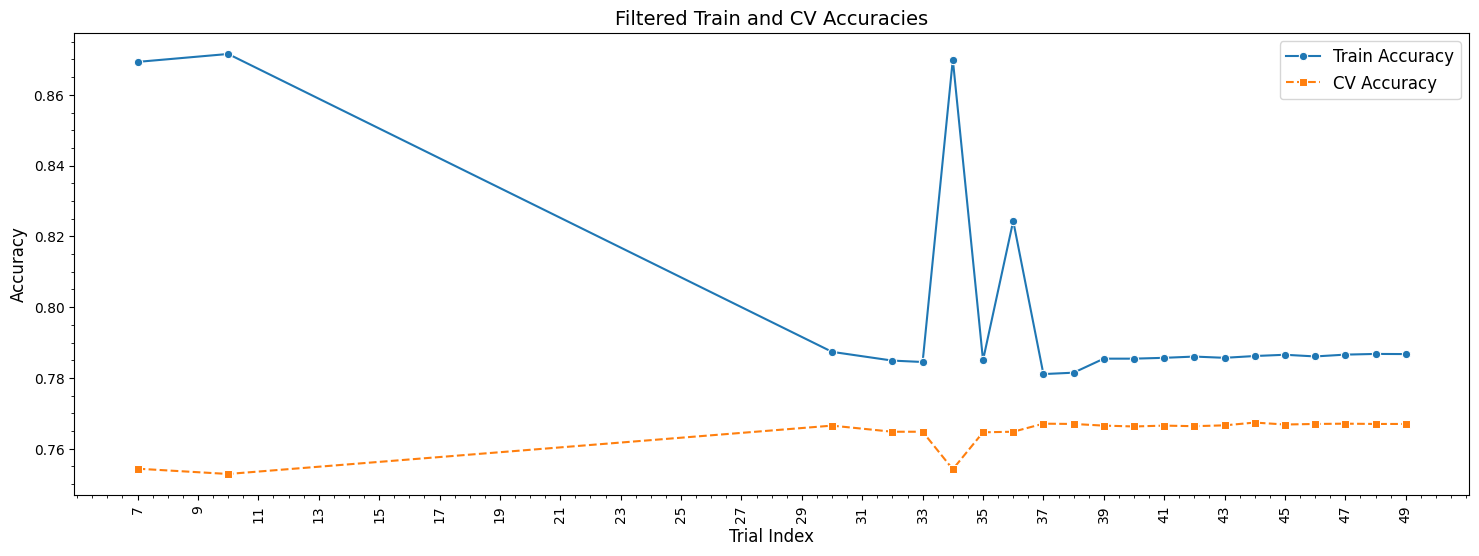

In [32]:
# Define the threshold values for filtering
threshold_train_min = 0.0
threshold_train_max = 1.0
threshold_cv = 0.75

# Initialize lists to store filtered results
filtered_train_accuracies = []
filtered_cv_accuracies = []
filtered_trial_numbers = []

# Iterate through the completed trials in the Optuna study
for trial in study.trials:
    if trial.state == op.trial.TrialState.COMPLETE:
        train_acc = trial.user_attrs.get("train_score", 0)
        cv_acc = trial.user_attrs.get("test_score", 0)
        if threshold_train_min <= train_acc <= threshold_train_max and cv_acc >= threshold_cv:
            filtered_train_accuracies.append(train_acc)
            filtered_cv_accuracies.append(cv_acc)
            filtered_trial_numbers.append(trial.number)

# Create a DataFrame for filtered results
data = pd.DataFrame({
    'Trial Index': filtered_trial_numbers,
    'Train Accuracy': filtered_train_accuracies,
    'CV Accuracy': filtered_cv_accuracies
})

# Plot the results using seaborn
plt.figure(figsize=(18, 6))
sns.lineplot(x="Trial Index", y="Train Accuracy", data=data, label="Train Accuracy", marker='o', linestyle='-')
sns.lineplot(x="Trial Index", y="CV Accuracy", data=data, label="CV Accuracy", marker='s', linestyle='--')

plt.xlabel("Trial Index", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Filtered Train and CV Accuracies", fontsize=14)
plt.legend(fontsize=12)

plt.minorticks_on()
plt.xticks(ticks=range(min(filtered_trial_numbers), max(filtered_trial_numbers)+1, 2), rotation=90)

plt.show()


In [34]:
study.trials_dataframe().iloc[[38,44]]

,number,value,datetime_start,datetime_complete,duration,params_Algorithm,params_C,params_Degree,params_Gamma,params_Kernel,params_criterion,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_poly_degree,params_solver_penalty,user_attrs_test_score,user_attrs_train_score,state
38,38,0.767014,2025-02-04 23:49:09.005191,2025-02-05 00:17:45.299686,0 days 00:28:36.294495,Logistic Regression,0.148627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"(saga, l1)",0.767014,0.781498,COMPLETE
44,44,0.767406,2025-02-05 00:17:45.312027,2025-02-05 00:26:53.815979,0 days 00:09:08.503952,Logistic Regression,0.854652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"(saga, l1)",0.767406,0.786207,COMPLETE


#### Training the model

In [40]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [42]:
# Create LogisticRegression model with L1 penalty
model = make_pipeline(
    LogisticRegression(
        penalty='l1',
        C=0.8546520978386443,
        random_state=42,
        solver='saga',
        max_iter=1000,
        n_jobs=-1
    )
)

In [44]:
lor_model = model.fit(X_train_poly, y_train)

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
y_pred = lor_model.predict(X_test_poly)

In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.54      0.61      0.57      1593
           1       0.55      0.48      0.51      1592

    accuracy                           0.55      3185
   macro avg       0.55      0.55      0.54      3185
weighted avg       0.55      0.55      0.54      3185



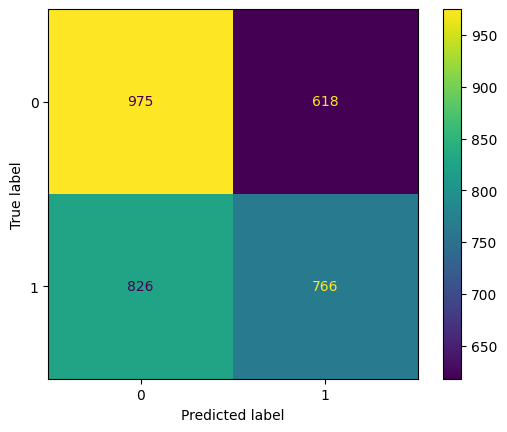

In [48]:
CM=confusion_matrix(y_test,y_pred,labels=lor_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=lor_model.classes_)
disp.plot()

### Save the Model

In [49]:
joblib.dump(lor_model, "Heart_Attack_Prediction_model.pkl")

['Heart_Attack_Prediction_model.pkl']